In [1]:
import os
import pandas as pd
import numpy as np
import top_order_book as tob
import data_parse
import matplotlib.pyplot as plt
import seaborn as sns

from time import process_time

In [246]:
from scipy.optimize import curve_fit

# Define functions for optimization
def scale_function(x, alpha, beta):
    """
    Scaling function
    """
    return x / np.power(1 + np.power(abs(x), alpha), beta/alpha)

def func(qT, chi, kappa, alpha, beta, gamma):
    """
    Function used for optimization
    """
    q = qT[0]
    T = qT[1]
    x = q / np.power(T, kappa)
    return np.power(T, chi) * scale_function( x, alpha, beta ) * gamma

#
def scale_function_2(x, zeta):
    """
    Scaling function
    """
    return x / np.sign(x) * np.power(abs(x), zeta)

def func_2(qT, chi, kappa, zeta, gamma):
    """
    Function used for optimization
    """
    q = qT[0]
    T = qT[1]
    x = q / np.power(T, kappa)
    return np.power(T, chi) * scale_function_2( x, zeta ) * gamma

# 
def scale_function_3(x):
    return np.tanh(x)

def func_3(qT, chi, kappa, gamma):
    q = qT[0]
    T = qT[1]
    x = q / np.power(T, kappa)
    return np.power(T, chi) * scale_function_3( x ) * gamma

In [239]:
directory = 'output/'

files = os.listdir(directory)
data = pd.DataFrame()
for file in files:
    if file.startswith(r'impact_vs_imbalance_') & file.endswith('.csv'):
        f = open(directory + file, 'r')
        data = data.append(pd.read_csv(f, index_col=0), ignore_index=True)
        f.close()

In [240]:
# header incorrect, need rename
data.columns = ['qi', 'yi', 'T']

# reoganize columes
data = data.reindex(columns=['qi', 'T', 'yi'])

data

,qi,T,yi
0,-0.000400,5,0.000000
1,-0.000384,5,0.000000
2,-0.000349,5,0.000000
3,-0.000342,5,0.000000
4,-0.000322,5,0.000000
...,...,...,...
104170,0.002008,100,19.912864
104171,0.002334,100,11.378780
104172,0.002528,100,14.223475
104173,0.003592,100,0.000000


In [189]:
durations = [5, 10, 20, 50, 100]

In [190]:
popt, pcov = curve_fit(func, np.transpose(data.iloc[:, :2].to_numpy()), 
                       data.iloc[:, 2].to_numpy(), 
                       bounds=(0, np.inf))
popt

array([2.58646534e+00, 2.98744707e-32, 7.31185853e-01, 2.87512574e+02])

In [66]:
temp = data[data['T'] == durations[T]]

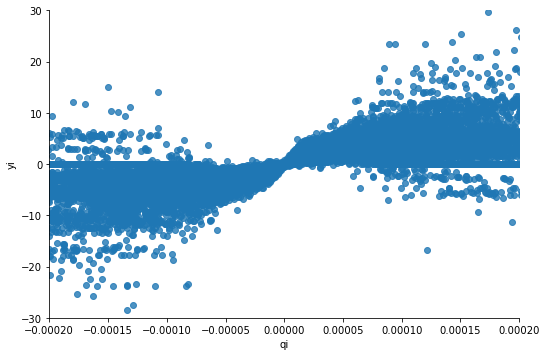

In [68]:
# plotting in seaborn
sns.lmplot(x='qi', y='yi', data=temp, aspect=1.5)
plt.xlim(-0.0002, 0.0002)
plt.ylim(-30, 30)
plt.show()

In [ ]:
# Too much noise, will need binning

In [226]:
data_binned = pd.DataFrame()

for T in durations:
    temp = data[data['T'] == T]
    qmax = 0.0002
    bin_size = 51
    
    # limit value for 'qi'
    temp = temp[(temp['qi'] > -qmax) & (temp['qi'] < qmax)]
    
    # bin
    temp['bin'] = pd.cut(temp['qi'], bin_size)
    
    # find average
    temp = temp.groupby(['bin']).mean().reset_index()
    data_binned = data_binned.append(temp.iloc[:, 1:], ignore_index=True)

In [227]:
data_binned

,qi,T,yi
0,-0.000196,5,-2.002097
1,-0.000188,5,-2.661539
2,-0.000180,5,-1.935022
3,-0.000172,5,-2.649312
4,-0.000165,5,-3.026305
...,...,...,...
250,0.000165,100,17.631021
251,0.000172,100,11.890470
252,0.000180,100,12.444646
253,0.000188,100,12.237543


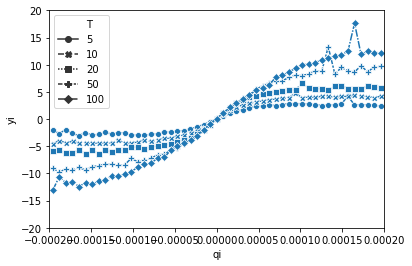

In [228]:
# plotting in seaborn
sns.lineplot(x='qi', y='yi', data=data_binned, style="T", 
             markers=True, legend='brief')
plt.xlim(-qmax, qmax)
plt.ylim(-20, 20)
plt.show()

In [92]:
#popt, pcov = curve_fit(func, np.transpose(data.iloc[:, :2].to_numpy()), data.iloc[:, 2].to_numpy(), bounds=(0, np.inf))
#popt

array([2.58646534e+00, 2.98744707e-32, 7.31185853e-01, 2.87512574e+02])

In [247]:
popt, pcov = curve_fit(func, np.transpose(data_binned.iloc[:, :2].to_numpy()), 
                       data_binned.iloc[:, 2].to_numpy(), #p0=[1., 0.5, 2., 1.],
                       bounds=(0, np.inf))
popt

array([8.02846949e-01, 3.75778154e-01, 1.13992899e+03, 4.03498449e+03,
       1.13414150e+04])

In [248]:
popt2, pcov2 = curve_fit(func_2, np.transpose(data_binned.iloc[:, :2].to_numpy()), 
                       data_binned.iloc[:, 2].to_numpy(), 
                       bounds=(0, np.inf))
popt2

array([0.99997221, 0.99998982, 1.00000281, 0.99999312])

In [249]:
popt3, pcov3 = curve_fit(func_3, np.transpose(data_binned.iloc[:, :2].to_numpy()), 
                       data_binned.iloc[:, 2].to_numpy(), 
                       bounds=(0, np.inf))
popt3

array([8.18913479e-01, 3.91844328e-01, 1.13413990e+04])

In [251]:
func([0.01, 5], *popt)

225.51504523678418